In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [63]:
# Загрузим тренировочные и тестовые данные
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


In [64]:
# Отсортируем по дате, чтобы потом разделить на трейн/тест по времени
df_train = df_train.sort_values('Deal_date')

# Подготовка данных

In [65]:
# Функция для заполнения пропусков в данных
def fill_missing_data(data: pd.DataFrame):
    # Захешированную информацию по гномам - средним
    for feature in [1, 2, 3]:
        col_name = f"Secret_dwarf_info_{feature}"
        mean_ = data[col_name].mean()
        data[col_name] = data[col_name].fillna(mean_)

    # Регион - самым популярным
    mode_region_value = data["Region"].mode()[0]
    data["Region"] = data["Region"].fillna(mode_region_value)

    # Первую дату дефолта - отдаленным от всех остальных значений "выбросом",
    # например, год перед минимальным значением в датасете

    min_date_str = data.First_default_date.dropna().min()

    min_date = datetime.datetime.strptime(min_date_str, "%Y-%m-%d")

    date_for_missing_values = min_date - \
                              datetime.timedelta(days=365)

    date_ = str(date_for_missing_values)[:10]

    data["First_default_date"] = data["First_default_date"].fillna(date_)

    # Количество успешных сделок - нулем
    data["Successful_deals_count"] = data["Successful_deals_count"].fillna(0)

    return

In [66]:
# Применим функцию на тренировочных и тестовых данных

fill_missing_data(df_train)
fill_missing_data(df_test)

# Проверим, что пропусков нет

df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [67]:
# Функция для генерации новых признаков


def create_new_features(data):
    # Преобразуем даты в год-месяц-день
    data["First_deal_date"] = pd.to_datetime(data["First_deal_date"])
    data["First_deal_year"] = data["First_deal_date"].apply(lambda x: x.year)
    data["First_deal_month"] = data["First_deal_date"].apply(lambda x: x.month)
    data["First_deal_day"] = data["First_deal_date"].apply(lambda x: x.day)

    data["Deal_date"] = pd.to_datetime(data["Deal_date"])
    data["Deal_year"] = data["Deal_date"].apply(lambda x: x.year)
    data["Deal_month"] = data["Deal_date"].apply(lambda x: x.month)
    data["Deal_day"] = data["Deal_date"].apply(lambda x: x.day)

    data["First_default_date"] = pd.to_datetime(data["First_default_date"])
    data["First_default_year"] = data["First_default_date"].apply(lambda x: x.year)
    data["First_default_month"] = data["First_default_date"].apply(lambda x: x.month)
    data["First_default_day"] = data["First_default_date"].apply(lambda x: x.day)

    # Создадим фичу 'время от первой сделки до первой просрочки' в днях
    data["Difference"] = (data["First_default_date"] - data["First_deal_date"]).dt.days

    # Удалим старые колонки с датами
    data.drop(
        ["First_deal_date", "Deal_date", "First_default_date"], axis=1, inplace=True
    )

    return

In [68]:
# Проверим результат трансформации
create_new_features(df_train)
create_new_features(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_year,First_default_month,First_default_day,Difference
1084,585679,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-3,5,2.5,-3,5,22.0,Male,0,2015,2,19,2015,2,24,2014,5,1,-294
1047,5954693,3.935514,-2.299065,5.26729,0.0,Tavern_district_4,7,2.5,-3,5,2.5,-3,5,30.0,Female,0,2015,2,14,2015,2,28,2014,5,1,-289
1396,6829250,3.935514,-2.299065,5.26729,2.0,Tavern_district_1,23,2.5,-2,5,2.5,-3,5,34.0,Female,0,2015,3,5,2015,3,10,2014,5,1,-308
717,6878449,3.935514,-2.299065,5.26729,2.0,Tavern_district_6,7,2.5,-3,5,2.5,-3,5,23.0,Female,1,2015,2,27,2015,3,11,2014,5,1,-302
2877,7185789,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-2,5,2.5,-3,5,32.0,Female,0,2015,2,17,2015,3,17,2014,5,1,-292


Найдем кореллирущие колонки.

[Код](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas) для поиска топ-N попарных корелляций

In [69]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df_train.select_dtypes('number'), 10)

First_default_year      Difference              0.848331
                        First_default_day       0.779611
First_default_day       Difference              0.743408
Deal_year               Deal_month              0.599111
First_deal_year         First_deal_month        0.580735
Secret_dwarf_info_2     Secret_dwarf_info_3     0.525387
Successful_deals_count  Hashed_deal_detail_3    0.500938
First_deal_year         Difference              0.451394
Secret_dwarf_info_1     Secret_dwarf_info_2     0.426617
First_deal_year         Deal_year               0.357647
dtype: float64

Удалим `'First_default_year'`

# EDA
Рассмотрим на распределение величин по признакам

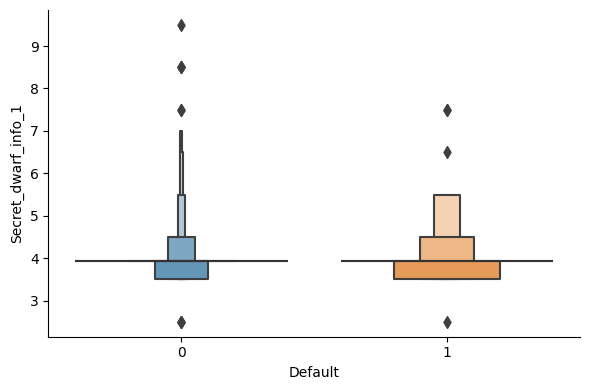

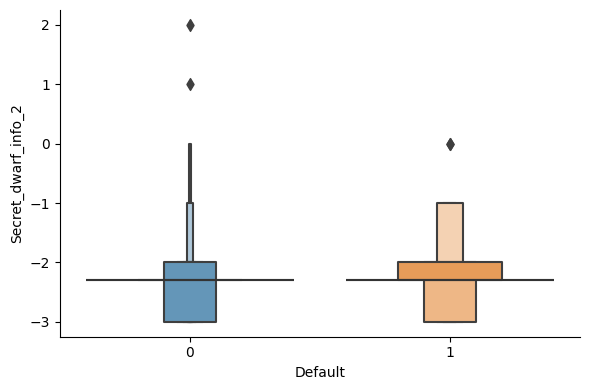

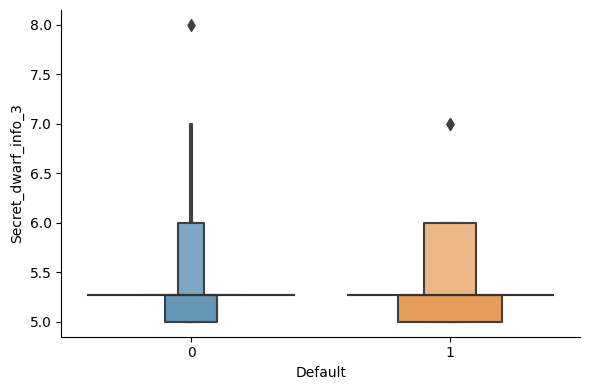

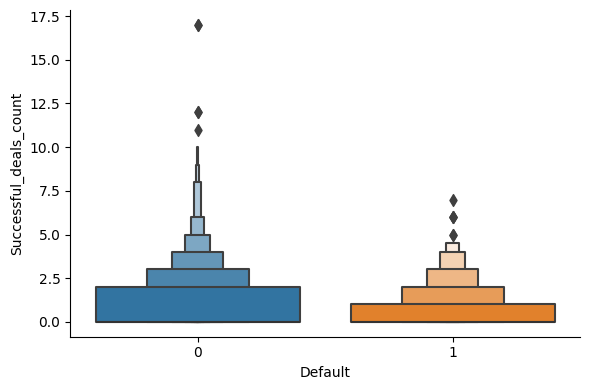

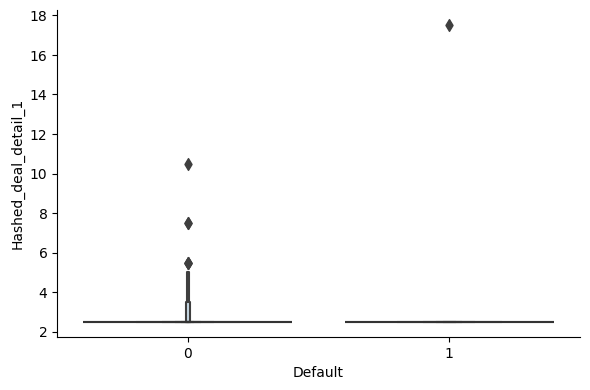

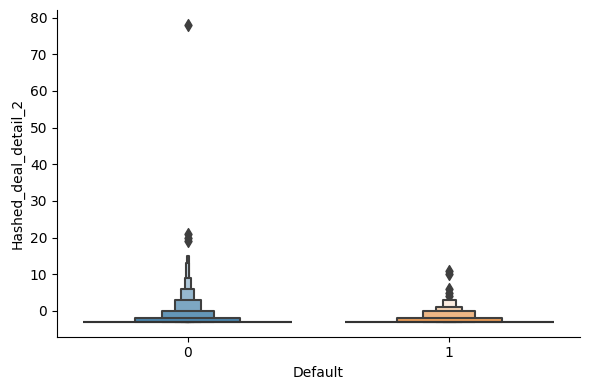

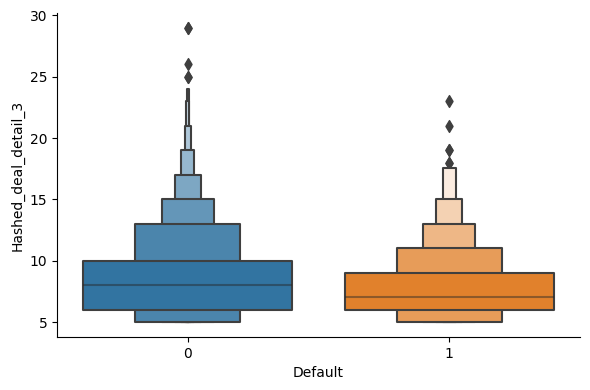

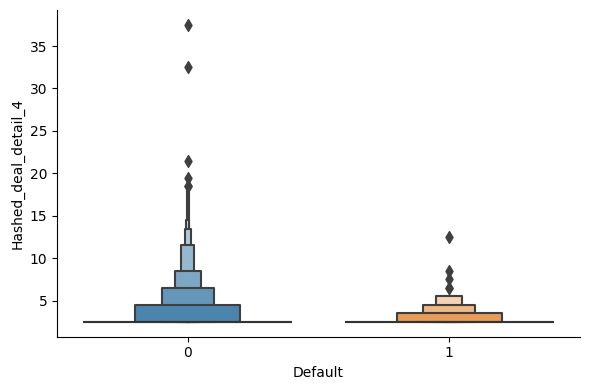

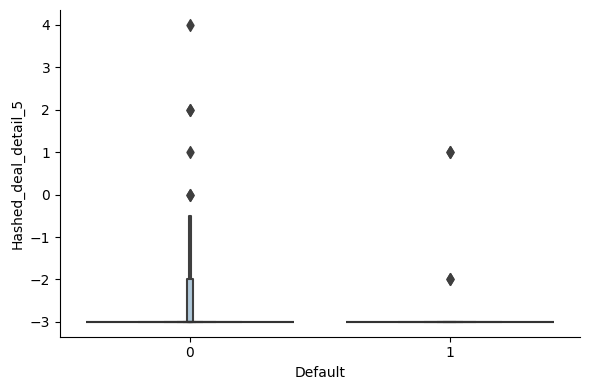

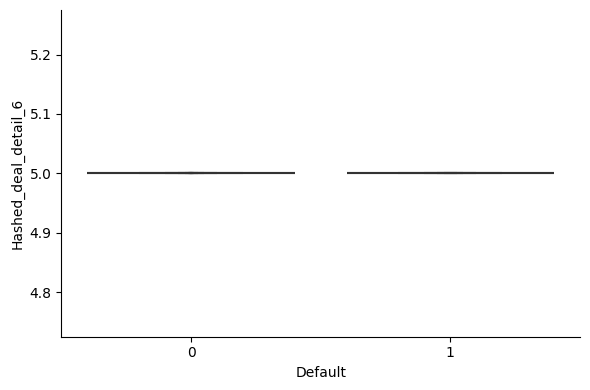

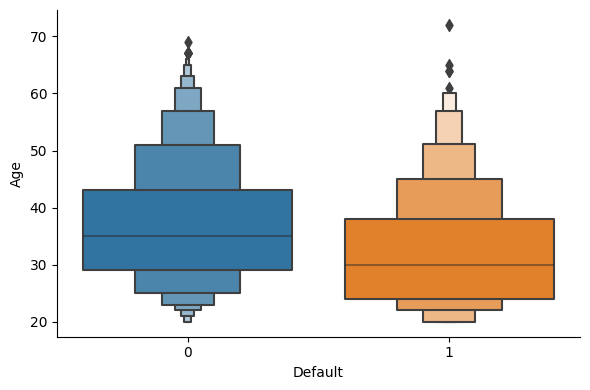

In [70]:
# Интересующие нас вещественные колонки
num_cols = [
    "Secret_dwarf_info_1",
    "Secret_dwarf_info_2",
    "Secret_dwarf_info_3",
    "Successful_deals_count",
    "Hashed_deal_detail_1",
    "Hashed_deal_detail_2",
    "Hashed_deal_detail_3",
    "Hashed_deal_detail_4",
    "Hashed_deal_detail_5",
    "Hashed_deal_detail_6",
    "Age",
]

for col in num_cols:
    sns.catplot(y=col, x="Default", data=df_train, kind="boxen", height=4, aspect=1.5)
plt.show()

In [71]:
df_train['Hashed_deal_detail_6'].nunique()

1

Видно, что `Hashed_deal_detail_6` постоянна для всех клиентов и эту колонку можно удалить.

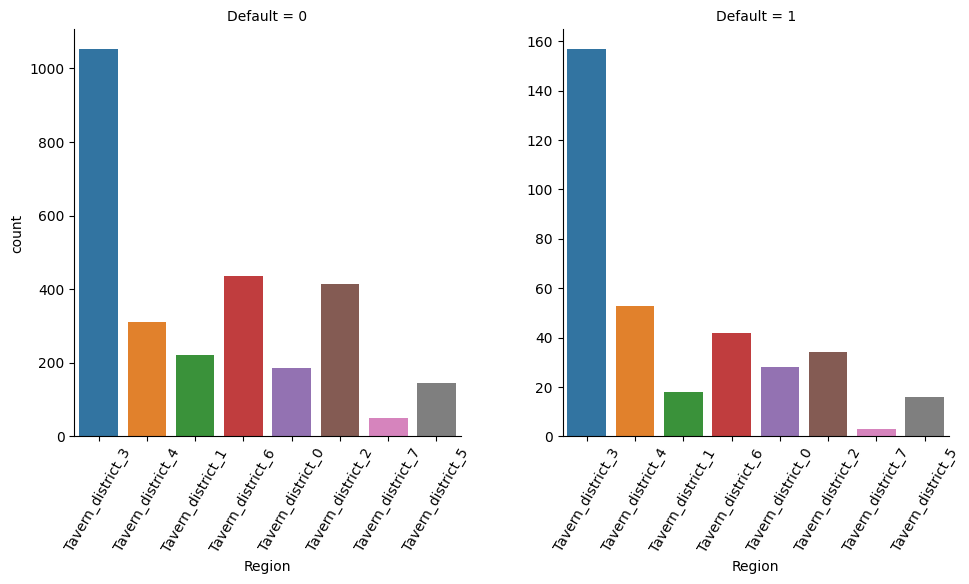

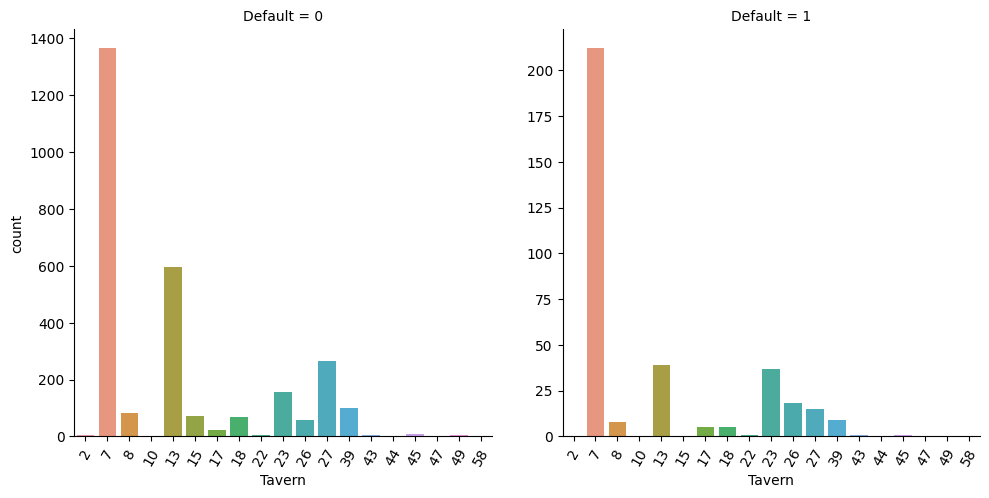

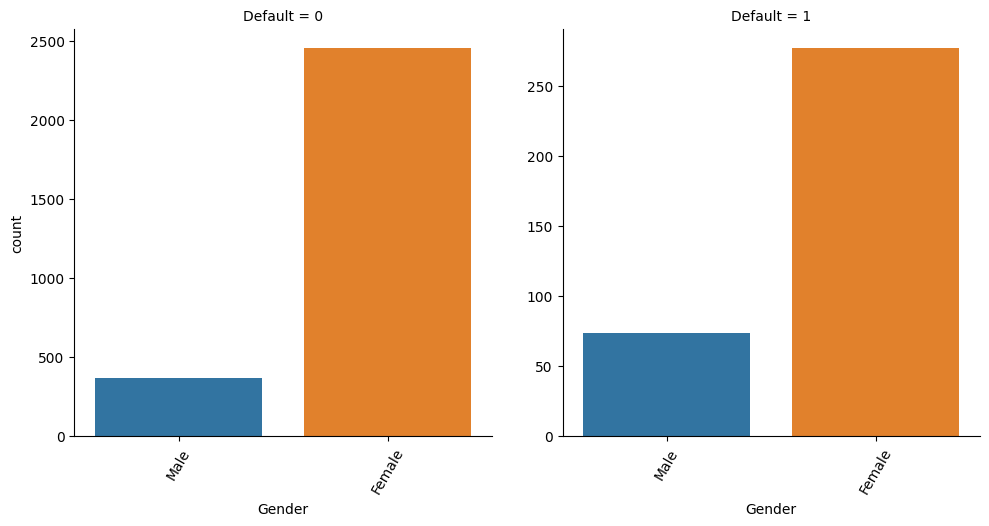

In [72]:
cat_cols = ['Region', 'Tavern', 'Gender']
for col in cat_cols:
    g = sns.catplot(x=col, kind='count', col='Default', data=df_train, sharey=False)
    g.set_xticklabels(rotation=60)

In [73]:
def column_delete(data):
    
    data.drop(['Hashed_deal_detail_6', 'First_default_year'], axis=1, inplace=True)
    
    return

In [74]:
# Применим функцию

column_delete(df_train)
column_delete(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,Gender,Default,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_month,First_default_day,Difference
1084,585679,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-3,5,2.5,-3,22.0,Male,0,2015,2,19,2015,2,24,5,1,-294
1047,5954693,3.935514,-2.299065,5.26729,0.0,Tavern_district_4,7,2.5,-3,5,2.5,-3,30.0,Female,0,2015,2,14,2015,2,28,5,1,-289
1396,6829250,3.935514,-2.299065,5.26729,2.0,Tavern_district_1,23,2.5,-2,5,2.5,-3,34.0,Female,0,2015,3,5,2015,3,10,5,1,-308
717,6878449,3.935514,-2.299065,5.26729,2.0,Tavern_district_6,7,2.5,-3,5,2.5,-3,23.0,Female,1,2015,2,27,2015,3,11,5,1,-302
2877,7185789,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-2,5,2.5,-3,32.0,Female,0,2015,2,17,2015,3,17,5,1,-292


# Обучение модели

In [75]:
# Разделим таргеты и фичи

X = df_train.drop(['Default', 'Deal_id'], axis=1)
Y = df_train['Default']

In [76]:
# Разделим колонки на вещественные, поверх которых применим StandatdScaler, и категориальные (для catboost'а)
num_cols = X.columns.tolist()
cat_cols = ['Tavern', 'Region', 'Gender']
num_cols = [col for col in num_cols if col not in cat_cols]
num_cols

['Secret_dwarf_info_1',
 'Secret_dwarf_info_2',
 'Secret_dwarf_info_3',
 'Successful_deals_count',
 'Hashed_deal_detail_1',
 'Hashed_deal_detail_2',
 'Hashed_deal_detail_3',
 'Hashed_deal_detail_4',
 'Hashed_deal_detail_5',
 'Age',
 'First_deal_year',
 'First_deal_month',
 'First_deal_day',
 'Deal_year',
 'Deal_month',
 'Deal_day',
 'First_default_month',
 'First_default_day',
 'Difference']

In [77]:
# Раздлим обущающую выборку на трейн и тест
# Данные отсортированы по дате, чтобы не подглядывать в будущее 
# первые 80% - тренировочная выборка

threshold = int(X.shape[0] * 0.8)
X_train, X_test = X.iloc[:threshold, :], X.iloc[threshold:, :]
y_train, y_test = Y.iloc[:threshold], Y.iloc[threshold:]

X_train.shape

(2534, 22)

In [78]:
# Применим StandartScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

t = ColumnTransformer(transformers=[("scaler", StandardScaler(), num_cols)], remainder='passthrough')

In [79]:
# Трансофрмер возвращает np.ndarray, обратно преобразуем данные в DataFrame
columns = num_cols + cat_cols
X_train = pd.DataFrame(t.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(t.transform(X_test), columns=columns)
X_train.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Age,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_month,First_default_day,Difference,Tavern,Region,Gender
0,0.004427,0.007,0.000525,-0.613641,-0.04608,-0.297247,-0.986959,-0.326955,-0.080852,-1.300395,-0.549689,-1.362268,0.322632,-1.578087,-1.268074,0.903649,-0.088052,-0.376321,0.474581,Tavern_district_3,23,Male
1,0.004427,0.007,0.000525,-0.613641,-0.04608,-0.297247,-0.986959,-0.326955,-0.080852,-0.571328,-0.549689,-1.362268,-0.249962,-1.578087,-1.268074,1.358344,-0.088052,-0.376321,0.493368,Tavern_district_4,7,Female
2,0.004427,0.007,0.000525,0.753964,-0.04608,0.252151,-0.986959,-0.326955,-0.080852,-0.206794,-0.549689,-1.07477,-1.280631,-1.578087,-0.956587,-0.687785,-0.088052,-0.376321,0.421976,Tavern_district_1,23,Female
3,0.004427,0.007,0.000525,0.753964,-0.04608,-0.297247,-0.986959,-0.326955,-0.080852,-1.209262,-0.549689,-1.362268,1.238783,-1.578087,-0.956587,-0.574111,-0.088052,-0.376321,0.444521,Tavern_district_6,7,Female
4,0.004427,0.007,0.000525,-0.613641,-0.04608,0.252151,-0.986959,-0.326955,-0.080852,-0.389061,-0.549689,-1.362268,0.093594,-1.578087,-0.956587,0.107932,-0.088052,-0.376321,0.482096,Tavern_district_3,23,Female


In [80]:
# Обучим catboost classifier
catboost = CatBoostClassifier(cat_features=cat_cols, task_type='GPU', max_depth=1, learning_rate=0.01, n_estimators=3000)
catboost.fit(X_train, y_train)

0:	learn: 0.6851035	total: 32.7ms	remaining: 1m 37s
1:	learn: 0.6773405	total: 57.4ms	remaining: 1m 26s
2:	learn: 0.6697934	total: 80.9ms	remaining: 1m 20s
3:	learn: 0.6623896	total: 105ms	remaining: 1m 18s
4:	learn: 0.6553206	total: 130ms	remaining: 1m 17s
5:	learn: 0.6484019	total: 155ms	remaining: 1m 17s
6:	learn: 0.6416590	total: 180ms	remaining: 1m 16s
7:	learn: 0.6350746	total: 204ms	remaining: 1m 16s
8:	learn: 0.6287790	total: 228ms	remaining: 1m 15s
9:	learn: 0.6223746	total: 253ms	remaining: 1m 15s
10:	learn: 0.6162404	total: 278ms	remaining: 1m 15s
11:	learn: 0.6099876	total: 303ms	remaining: 1m 15s
12:	learn: 0.6039861	total: 327ms	remaining: 1m 15s
13:	learn: 0.5983437	total: 353ms	remaining: 1m 15s
14:	learn: 0.5925139	total: 378ms	remaining: 1m 15s
15:	learn: 0.5868248	total: 402ms	remaining: 1m 14s
16:	learn: 0.5813951	total: 425ms	remaining: 1m 14s
17:	learn: 0.5762709	total: 449ms	remaining: 1m 14s
18:	learn: 0.5712014	total: 493ms	remaining: 1m 17s
19:	learn: 0.566145

In [81]:
print(f'ROC-AUC: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:,1]):.3f}')

ROC-AUC: 0.713


In [82]:
# Тренируем модель на всех данных
X = pd.DataFrame(t.fit_transform(X), columns=columns)
catboost.fit(X, Y)

0:	learn: 0.6846521	total: 24.1ms	remaining: 1m 12s
1:	learn: 0.6766831	total: 46.8ms	remaining: 1m 10s
2:	learn: 0.6685986	total: 73ms	remaining: 1m 12s
3:	learn: 0.6607483	total: 96.7ms	remaining: 1m 12s
4:	learn: 0.6532145	total: 122ms	remaining: 1m 13s
5:	learn: 0.6457298	total: 148ms	remaining: 1m 14s
6:	learn: 0.6382805	total: 177ms	remaining: 1m 15s
7:	learn: 0.6313826	total: 204ms	remaining: 1m 16s
8:	learn: 0.6246482	total: 231ms	remaining: 1m 16s
9:	learn: 0.6180136	total: 258ms	remaining: 1m 17s
10:	learn: 0.6114838	total: 292ms	remaining: 1m 19s
11:	learn: 0.6048540	total: 320ms	remaining: 1m 19s
12:	learn: 0.5985140	total: 349ms	remaining: 1m 20s
13:	learn: 0.5924605	total: 379ms	remaining: 1m 20s
14:	learn: 0.5862870	total: 406ms	remaining: 1m 20s
15:	learn: 0.5802642	total: 431ms	remaining: 1m 20s
16:	learn: 0.5745367	total: 458ms	remaining: 1m 20s
17:	learn: 0.5690461	total: 487ms	remaining: 1m 20s
18:	learn: 0.5636642	total: 518ms	remaining: 1m 21s
19:	learn: 0.5585055

In [83]:
# Предсказываем значения для тестовых данных
test_data = pd.DataFrame(t.fit_transform(df_test.drop(['Deal_id'], axis=1)), columns=columns)


submission = df_test['Deal_id'].copy().to_frame()
submission['Prediction'] = catboost.predict_proba(test_data)[:, 1]

submission.head()

,Deal_id,Prediction
0,72875713,0.055872
1,75825544,0.024501
2,81809181,0.122831
3,87083256,0.117379
4,84651519,0.119843


In [84]:
# Cохраняем svc для отправки файла на проверку
submission.to_csv('prediction.csv', index=False)